In [1]:
import os
import re
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from botorch import fit_gpytorch_mll
from botorch.models.model_list_gp_regression import ModelListGP
from gpytorch.likelihoods import FixedNoiseGaussianLikelihood
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood

from gskgpr import GaussianStringKernelGP
from seq2ascii import Seq2Ascii

In [2]:
REF_POINT = torch.Tensor([-50, -50])
device = "cpu"

In [3]:
def load_json_res(pcc, data_dir):
    with open(f"{data_dir}/{pcc}_FEN.JSON") as f:
        rep = json.load(f)
    F_fen = rep["FE"]
    F_fen_err = rep["FE_error"]

    with open(f"{data_dir}/{pcc}_DEC.JSON") as f:
        rep = json.load(f)
    F_dec = rep["FE"]
    F_dec_err = rep["FE_error"]
    return {"PCC": [rep["PCC"]], "F_FEN": [float(F_fen)], "err_FEN": [float(F_fen_err)],
             "F_DEC": [float(F_dec)], "err_DEC": [float(F_dec_err)]}

def load_data(data_dir):
    PCC_list = []
    for folder in os.listdir(data_dir):
        if re.match("[A-Z]{5}_[A-Z]{3}", folder):
            PCC_list.append(folder.split("_")[0])

    PCC_list = set(PCC_list)
    data = []
    for pcc in PCC_list:
        try:
            data.append(pd.DataFrame(load_json_res(pcc, data_dir)))
        except:
            print(f"Skipping {pcc}.")

    data = pd.concat(data)
    data.reset_index(inplace=True, drop=True)
    return data

def initialize_model(train_x, train_y, err_y, translator):
    models = [
        GaussianStringKernelGP(train_x=train_x, train_y=train_y[:, 0], 
                            likelihood=FixedNoiseGaussianLikelihood(noise=err_y[:, 0]), 
                            translator=translator),
        GaussianStringKernelGP(train_x=train_x, train_y=train_y[:, 1],
                            likelihood=FixedNoiseGaussianLikelihood(noise=err_y[:, 1]), 
                            translator=translator)
    ]
    model = ModelListGP(*models).to(device)
    mll = SumMarginalLogLikelihood(model.likelihood, model).to(device)
    return model, mll

def fit_gpytorch_model(mll, optimizer, n_iters=100):
    for i in range(n_iters):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = mll.model(*mll.model.train_inputs)
        # Calc loss and backprop gradients
        loss = -mll(output, mll.model.train_targets)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f   sigma11: %.3f   sigma21: %.3f   sigma12: %.3f   sigma22: %.3f' % (
            i + 1, n_iters, loss.item(),
            mll.model.models[0].covar_module.sigma1.item(),
            mll.model.models[0].covar_module.sigma2.item(),
            mll.model.models[1].covar_module.sigma1.item(),
            mll.model.models[1].covar_module.sigma2.item(),
        ))
        optimizer.step()

In [4]:
dataset = load_data("/Users/arminsh/Documents/FEN-HTVS/results")
dataset["ddG_sen"] = -1*dataset.F_FEN
dataset["ddG_spe"] = dataset.F_DEC-dataset.F_FEN
dataset["sen_var"] = dataset.err_FEN
dataset["spe_var"] = np.sqrt(dataset.err_FEN**2 + dataset.err_DEC**2)
dataset.ddG_sen = (dataset.ddG_sen - dataset.ddG_sen.mean())/dataset.ddG_sen.std()
dataset.sen_var = dataset.sen_var/dataset.ddG_sen.std()
dataset.ddG_spe = (dataset.ddG_spe - dataset.ddG_spe.mean())/dataset.ddG_spe.std()
dataset.spe_var = dataset.spe_var/dataset.ddG_spe.std()

In [5]:
translator = Seq2Ascii("/Users/arminsh/Documents/FEN-HTVS/MFMOBO/AA.blosum62.pckl")

fspace = []
with open("/Users/arminsh/Documents/FEN-HTVS/gen_input_space/full_space.txt") as f:
    line = f.readline()
    while line:
        fspace.append(line.split()[0])
        line = f.readline()

translator.fit(fspace)

In [6]:
encoded_x = translator.encode_to_int(dataset.PCC.to_list()).to(device)
FE_sen = torch.tensor(dataset.ddG_sen.to_numpy()).float().to(device)
FE_sen_var = torch.tensor(dataset.sen_var.to_numpy()).float().to(device)
FE_spe = torch.tensor(dataset.ddG_spe.to_numpy()).float().to(device)
FE_spe_var = torch.tensor(dataset.spe_var.to_numpy()).float().to(device)
train_y = torch.cat([FE_sen.view(-1, 1), FE_spe.view(-1, 1)], dim=1)
err_y = torch.cat([FE_sen_var.view(-1, 1), FE_spe_var.view(-1, 1)], dim=1)

In [7]:
model, mll = initialize_model(encoded_x, train_y, err_y, translator)

In [8]:
fit_gpytorch_mll(mll)

SumMarginalLogLikelihood(
  (likelihood): LikelihoodList(
    (likelihoods): ModuleList(
      (0-1): 2 x FixedNoiseGaussianLikelihood(
        (noise_covar): FixedGaussianNoise()
      )
    )
  )
  (model): ModelListGP(
    (models): ModuleList(
      (0-1): 2 x GaussianStringKernelGP(
        (likelihood): FixedNoiseGaussianLikelihood(
          (noise_covar): FixedGaussianNoise()
        )
        (mean_module): ConstantMean()
        (covar_module): GenericStringKernel(
          (raw_sigma1_constraint): Positive()
          (raw_sigma2_constraint): Positive()
        )
      )
    )
    (likelihood): LikelihoodList(
      (likelihoods): ModuleList(
        (0-1): 2 x FixedNoiseGaussianLikelihood(
          (noise_covar): FixedGaussianNoise()
        )
      )
    )
  )
  (mlls): ModuleList(
    (0-1): 2 x ExactMarginalLogLikelihood(
      (likelihood): FixedNoiseGaussianLikelihood(
        (noise_covar): FixedGaussianNoise()
      )
      (model): GaussianStringKernelGP(
        

In [8]:
model.train()
mll.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
fit_gpytorch_model(mll, optimizer, n_iters=500)
model.eval()
mll.eval()

Iter 1/500 - Loss: 1.392   sigma11: 0.693   sigma21: 0.693   sigma12: 0.693   sigma22: 0.693
Iter 2/500 - Loss: 1.383   sigma11: 0.644   sigma21: 0.644   sigma12: 0.744   sigma22: 0.744
Iter 3/500 - Loss: 1.375   sigma11: 0.599   sigma21: 0.599   sigma12: 0.798   sigma22: 0.798
Iter 4/500 - Loss: 1.370   sigma11: 0.559   sigma21: 0.556   sigma12: 0.854   sigma22: 0.854
Iter 5/500 - Loss: 1.366   sigma11: 0.524   sigma21: 0.517   sigma12: 0.913   sigma22: 0.912
Iter 6/500 - Loss: 1.363   sigma11: 0.497   sigma21: 0.482   sigma12: 0.974   sigma22: 0.972
Iter 7/500 - Loss: 1.360   sigma11: 0.479   sigma21: 0.451   sigma12: 1.037   sigma22: 1.034
Iter 8/500 - Loss: 1.358   sigma11: 0.469   sigma21: 0.423   sigma12: 1.102   sigma22: 1.097
Iter 9/500 - Loss: 1.355   sigma11: 0.464   sigma21: 0.399   sigma12: 1.169   sigma22: 1.161
Iter 10/500 - Loss: 1.353   sigma11: 0.464   sigma21: 0.377   sigma12: 1.237   sigma22: 1.225
Iter 11/500 - Loss: 1.351   sigma11: 0.467   sigma21: 0.358   sigma12

SumMarginalLogLikelihood(
  (likelihood): LikelihoodList(
    (likelihoods): ModuleList(
      (0-1): 2 x FixedNoiseGaussianLikelihood(
        (noise_covar): FixedGaussianNoise()
      )
    )
  )
  (model): ModelListGP(
    (models): ModuleList(
      (0-1): 2 x GaussianStringKernelGP(
        (likelihood): FixedNoiseGaussianLikelihood(
          (noise_covar): FixedGaussianNoise()
        )
        (mean_module): ConstantMean()
        (covar_module): GenericStringKernel(
          (raw_sigma1_constraint): Positive()
          (raw_sigma2_constraint): Positive()
        )
      )
    )
    (likelihood): LikelihoodList(
      (likelihoods): ModuleList(
        (0-1): 2 x FixedNoiseGaussianLikelihood(
          (noise_covar): FixedGaussianNoise()
        )
      )
    )
  )
  (mlls): ModuleList(
    (0-1): 2 x ExactMarginalLogLikelihood(
      (likelihood): FixedNoiseGaussianLikelihood(
        (noise_covar): FixedGaussianNoise()
      )
      (model): GaussianStringKernelGP(
        

In [9]:
full_space = torch.as_tensor(list(translator.int2str.keys())).view(-1, 1).to(device)

In [10]:
post = model.posterior(full_space)

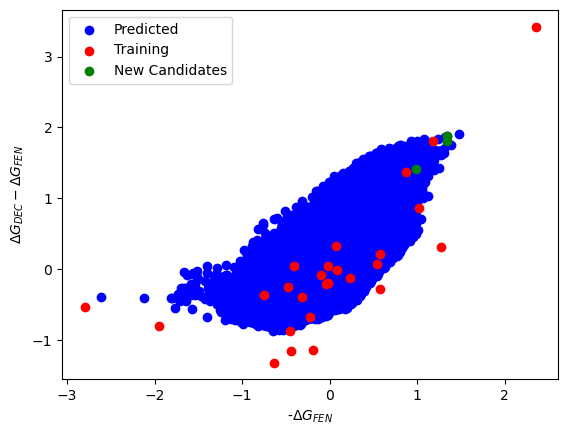

In [11]:
#plt.errorbar(x = post.mean[:, 0].detach().numpy(), y = post.mean[:, 1].detach().numpy(), xerr=post.variance[:, 0].sqrt().detach().numpy(), yerr=post.variance[:, 1].sqrt().detach().numpy(), fmt='o')
plt.scatter(x = post.mean[:, 0].detach().numpy(), y = post.mean[:, 1].detach().numpy(), color='blue', label="Predicted")
plt.scatter(x = train_y[:, 0].detach().numpy(), y = train_y[:, 1].detach().numpy(), color='red', label="Training")
new_x = ["WWWWL", "WWWWY", "WWYHV"]
new_x = translator.encode_to_int(new_x).to(device)
plt.scatter(x = post.mean[new_x, 0].detach().numpy(), y = post.mean[new_x, 1].detach().numpy(), color='green', label="New Candidates")
plt.xlabel(r"-$\Delta G_{FEN}$")
plt.ylabel(r"$\Delta G_{DEC}-\Delta G_{FEN}$")
plt.legend()
plt.show()

In [9]:
post_train = model.posterior(encoded_x)

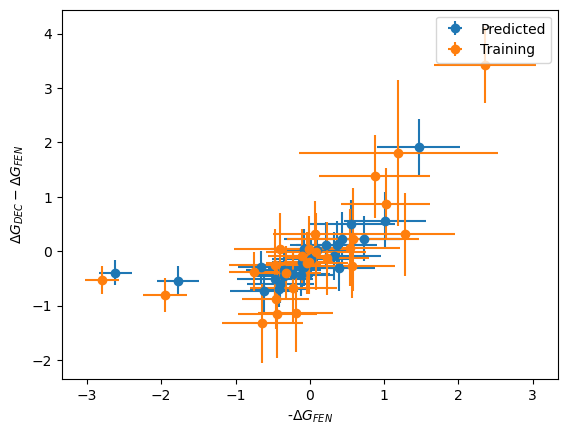

In [10]:
plt.errorbar(x = post_train.mean[:, 0].detach().numpy(), y = post_train.mean[:, 1].detach().numpy(),
             xerr=post_train.variance[:, 0].sqrt().detach().numpy(), yerr=post_train.variance[:, 1].sqrt().detach().numpy(), fmt='o', label="Predicted")
plt.errorbar(x = train_y[:, 0].detach().numpy(), y = train_y[:, 1].detach().numpy(),
             xerr=err_y[:, 0].sqrt().detach().numpy(), yerr=err_y[:, 1].sqrt().detach().numpy(), fmt='o', label="Training")
plt.xlabel(r"-$\Delta G_{FEN}$")
plt.ylabel(r"$\Delta G_{DEC}-\Delta G_{FEN}$")
plt.legend()
plt.show()

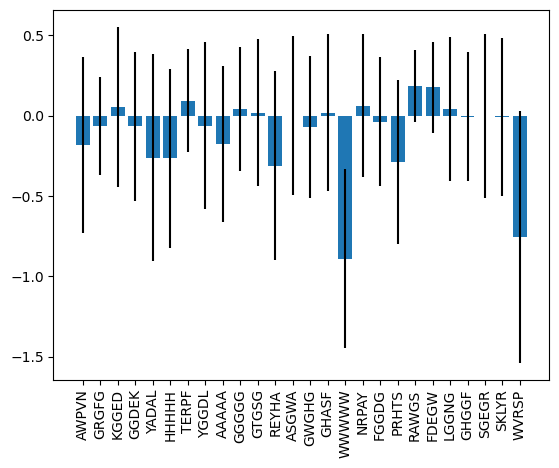

In [11]:
plt.bar(dataset.PCC.to_list(), post_train.mean[:, 0].detach().numpy()-train_y[:, 0].detach().numpy(),
        yerr=post_train.variance[:, 0].sqrt().detach().numpy(), label="Senstivity")
plt.xticks(rotation=90)
plt.show()

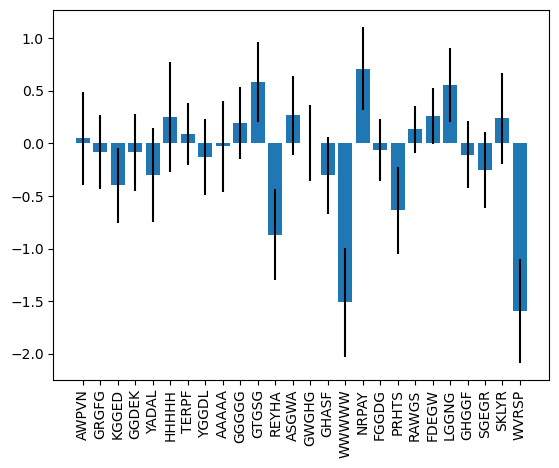

In [12]:
plt.bar(dataset.PCC.to_list(), post_train.mean[:, 1].detach().numpy()-train_y[:, 1].detach().numpy(),
        yerr=post_train.variance[:, 1].sqrt().detach().numpy(), label="Specificity")
plt.xticks(rotation=90)
plt.show()